# Ungraded Lab: Build a Multi-output Model

In this lab, we'll show how you can build models with more than one output. The dataset we will be working on is available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Energy+efficiency). It is an Energy Efficiency dataset which uses the bulding features (e.g. wall area, roof area) as inputs and has two outputs: Cooling Load and Heating Load. Let's see how we can build a model to train on this data.

## Imports

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split

## Utilities

We define a few utilities for data conversion and visualization to make our code more neat.

In [2]:
def format_output(data):
    y1 = data.pop('Y1')
    y1 = np.array(y1)
    y2 = data.pop('Y2')
    y2 = np.array(y2)
    return y1, y2


def norm(x):
    return (x - train_stats['mean']) / train_stats['std']


def plot_diff(y_true, y_pred, title=''):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.plot([-100, 100], [-100, 100])
    plt.show()


def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)
    plt.show()

## Prepare the Data

We download the dataset and format it for training.

In [3]:
# Specify data URI
URI = './data/ENB2012_data.xlsx'

# Use pandas excel reader
df = pd.read_excel(URI)
df = df.sample(frac=1).reset_index(drop=True)

# Split the data into train and test with 80 train / 20 test
train, test = train_test_split(df, test_size=0.2)
train_stats = train.describe()

# Get Y1 and Y2 as the 2 outputs and format them as np arrays
train_stats.pop('Y1')
train_stats.pop('Y2')
train_stats = train_stats.transpose()
train_Y = format_output(train)
test_Y = format_output(test)

# Normalize the training and test data
norm_train_X = norm(train)
norm_test_X = norm(test)

## Build the Model

Here is how we'll build the model using the functional syntax. Notice that we can specify a list of outputs (i.e. `[y1_output, y2_output]`) when we instantiate the `Model()` class.

In [4]:
# Define model layers.
input_layer = Input(shape=(len(train .columns),))
first_dense = Dense(units='128', activation='relu')(input_layer)
second_dense = Dense(units='128', activation='relu')(first_dense)

# Y1 output will be fed directly from the second dense
y1_output = Dense(units='1', name='y1_output')(second_dense)
third_dense = Dense(units='64', activation='relu')(second_dense)

# Y2 output will come via the third dense
y2_output = Dense(units='1', name='y2_output')(third_dense)

# Define the model with the input layer and a list of output layers
model = Model(inputs=input_layer, outputs=[y1_output, y2_output])

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          1152        input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          16512       dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           8256        dense_1[0][0]                    
______________________________________________________________________________________________

## Configure parameters

We specify the optimizer as well as the loss and metrics for each output.

In [5]:
# Specify the optimizer, and compile the model with loss functions for both outputs
optimizer = tf.keras.optimizers.SGD(lr=0.001)
model.compile(optimizer=optimizer,
              loss={'y1_output': 'mse', 'y2_output': 'mse'},
              metrics={'y1_output': tf.keras.metrics.RootMeanSquaredError(),
                       'y2_output': tf.keras.metrics.RootMeanSquaredError()})

## Train the Model

In [6]:
# Train the model for 500 epochs
history = model.fit(norm_train_X, train_Y,
                    epochs=500, batch_size=10, validation_data=(norm_test_X, test_Y))

Train on 614 samples, validate on 154 samples
Epoch 1/500
614/614 [==============================] - 1s 950us/sample - loss: 237.8915 - y1_output_loss: 111.5118 - y2_output_loss: 124.1414 - y1_output_root_mean_squared_error: 10.6106 - y2_output_root_mean_squared_error: 11.1941 - val_loss: 37.7240 - val_y1_output_loss: 16.0065 - val_y2_output_loss: 20.6094 - val_y1_output_root_mean_squared_error: 4.0677 - val_y2_output_root_mean_squared_error: 4.6020
Epoch 2/500
614/614 [==============================] - 0s 162us/sample - loss: 26.5016 - y1_output_loss: 10.4998 - y2_output_loss: 15.8086 - y1_output_root_mean_squared_error: 3.2556 - y2_output_root_mean_squared_error: 3.9879 - val_loss: 29.6273 - val_y1_output_loss: 12.7356 - val_y2_output_loss: 16.5970 - val_y1_output_root_mean_squared_error: 3.5903 - val_y2_output_root_mean_squared_error: 4.0911
Epoch 3/500
614/614 [==============================] - 0s 148us/sample - loss: 25.9230 - y1_output_loss: 9.8532 - y2_output_loss: 15.9298 - y1_

614/614 [==============================] - 0s 132us/sample - loss: 15.1425 - y1_output_loss: 5.5240 - y2_output_loss: 9.8068 - y1_output_root_mean_squared_error: 2.3509 - y2_output_root_mean_squared_error: 3.1010 - val_loss: 24.3496 - val_y1_output_loss: 6.6967 - val_y2_output_loss: 17.2000 - val_y1_output_root_mean_squared_error: 2.6303 - val_y2_output_root_mean_squared_error: 4.1751
Epoch 22/500
614/614 [==============================] - 0s 131us/sample - loss: 15.6936 - y1_output_loss: 5.4642 - y2_output_loss: 10.0819 - y1_output_root_mean_squared_error: 2.3488 - y2_output_root_mean_squared_error: 3.1901 - val_loss: 14.7024 - val_y1_output_loss: 5.8010 - val_y2_output_loss: 8.6610 - val_y1_output_root_mean_squared_error: 2.4450 - val_y2_output_root_mean_squared_error: 2.9537
Epoch 23/500
614/614 [==============================] - 0s 137us/sample - loss: 12.4393 - y1_output_loss: 5.0115 - y2_output_loss: 7.5683 - y1_output_root_mean_squared_error: 2.2346 - y2_output_root_mean_squared

614/614 [==============================] - 0s 131us/sample - loss: 7.7524 - y1_output_loss: 2.6683 - y2_output_loss: 5.0639 - y1_output_root_mean_squared_error: 1.6376 - y2_output_root_mean_squared_error: 2.2518 - val_loss: 8.3376 - val_y1_output_loss: 2.9197 - val_y2_output_loss: 5.2964 - val_y1_output_root_mean_squared_error: 1.7336 - val_y2_output_root_mean_squared_error: 2.3091
Epoch 42/500
614/614 [==============================] - 0s 130us/sample - loss: 7.2971 - y1_output_loss: 2.6251 - y2_output_loss: 4.6803 - y1_output_root_mean_squared_error: 1.6185 - y2_output_root_mean_squared_error: 2.1628 - val_loss: 8.0041 - val_y1_output_loss: 2.8007 - val_y2_output_loss: 5.0336 - val_y1_output_root_mean_squared_error: 1.7032 - val_y2_output_root_mean_squared_error: 2.2591
Epoch 43/500
614/614 [==============================] - 0s 130us/sample - loss: 9.4482 - y1_output_loss: 3.0933 - y2_output_loss: 6.3342 - y1_output_root_mean_squared_error: 1.7652 - y2_output_root_mean_squared_error:

Epoch 62/500
614/614 [==============================] - 0s 134us/sample - loss: 6.7040 - y1_output_loss: 2.2062 - y2_output_loss: 4.5044 - y1_output_root_mean_squared_error: 1.4913 - y2_output_root_mean_squared_error: 2.1166 - val_loss: 6.0566 - val_y1_output_loss: 1.8313 - val_y2_output_loss: 4.0869 - val_y1_output_root_mean_squared_error: 1.3761 - val_y2_output_root_mean_squared_error: 2.0403
Epoch 63/500
614/614 [==============================] - 0s 131us/sample - loss: 6.5562 - y1_output_loss: 1.6603 - y2_output_loss: 4.8359 - y1_output_root_mean_squared_error: 1.2942 - y2_output_root_mean_squared_error: 2.2094 - val_loss: 5.0665 - val_y1_output_loss: 1.4187 - val_y2_output_loss: 3.5376 - val_y1_output_root_mean_squared_error: 1.2094 - val_y2_output_root_mean_squared_error: 1.8984
Epoch 64/500
614/614 [==============================] - 0s 130us/sample - loss: 4.1777 - y1_output_loss: 1.1851 - y2_output_loss: 3.0650 - y1_output_root_mean_squared_error: 1.0904 - y2_output_root_mean_s

Epoch 83/500
614/614 [==============================] - 0s 128us/sample - loss: 3.5277 - y1_output_loss: 0.8008 - y2_output_loss: 2.7551 - y1_output_root_mean_squared_error: 0.8974 - y2_output_root_mean_squared_error: 1.6500 - val_loss: 11.0437 - val_y1_output_loss: 1.3469 - val_y2_output_loss: 9.5912 - val_y1_output_root_mean_squared_error: 1.1700 - val_y2_output_root_mean_squared_error: 3.1104
Epoch 84/500
614/614 [==============================] - 0s 130us/sample - loss: 4.1589 - y1_output_loss: 0.9096 - y2_output_loss: 3.2343 - y1_output_root_mean_squared_error: 0.9562 - y2_output_root_mean_squared_error: 1.8013 - val_loss: 6.4258 - val_y1_output_loss: 1.4109 - val_y2_output_loss: 5.1273 - val_y1_output_root_mean_squared_error: 1.1751 - val_y2_output_root_mean_squared_error: 2.2461
Epoch 85/500
614/614 [==============================] - 0s 137us/sample - loss: 3.2904 - y1_output_loss: 0.8740 - y2_output_loss: 2.4116 - y1_output_root_mean_squared_error: 0.9331 - y2_output_root_mean_

Epoch 104/500
614/614 [==============================] - 0s 129us/sample - loss: 22.3471 - y1_output_loss: 8.8123 - y2_output_loss: 13.3225 - y1_output_root_mean_squared_error: 2.9830 - y2_output_root_mean_squared_error: 3.6673 - val_loss: 4.2955 - val_y1_output_loss: 0.9008 - val_y2_output_loss: 3.3474 - val_y1_output_root_mean_squared_error: 0.9403 - val_y2_output_root_mean_squared_error: 1.8470
Epoch 105/500
614/614 [==============================] - 0s 130us/sample - loss: 3.5608 - y1_output_loss: 0.9143 - y2_output_loss: 2.6620 - y1_output_root_mean_squared_error: 0.9520 - y2_output_root_mean_squared_error: 1.6293 - val_loss: 9.0498 - val_y1_output_loss: 2.4177 - val_y2_output_loss: 6.7061 - val_y1_output_root_mean_squared_error: 1.5378 - val_y2_output_root_mean_squared_error: 2.5855
Epoch 106/500
614/614 [==============================] - 0s 127us/sample - loss: 2.4509 - y1_output_loss: 0.6073 - y2_output_loss: 1.8394 - y1_output_root_mean_squared_error: 0.7821 - y2_output_root_m

614/614 [==============================] - 0s 129us/sample - loss: 2.4809 - y1_output_loss: 0.5777 - y2_output_loss: 1.9070 - y1_output_root_mean_squared_error: 0.7620 - y2_output_root_mean_squared_error: 1.3785 - val_loss: 4.7847 - val_y1_output_loss: 0.6744 - val_y2_output_loss: 4.0393 - val_y1_output_root_mean_squared_error: 0.8268 - val_y2_output_root_mean_squared_error: 2.0251
Epoch 125/500
614/614 [==============================] - 0s 126us/sample - loss: 2.4572 - y1_output_loss: 0.5789 - y2_output_loss: 1.8554 - y1_output_root_mean_squared_error: 0.7644 - y2_output_root_mean_squared_error: 1.3686 - val_loss: 2.5188 - val_y1_output_loss: 0.3893 - val_y2_output_loss: 2.0748 - val_y1_output_root_mean_squared_error: 0.6216 - val_y2_output_root_mean_squared_error: 1.4603
Epoch 126/500
614/614 [==============================] - 0s 127us/sample - loss: 2.0650 - y1_output_loss: 0.4304 - y2_output_loss: 1.6663 - y1_output_root_mean_squared_error: 0.6469 - y2_output_root_mean_squared_erro

Epoch 145/500
614/614 [==============================] - 0s 132us/sample - loss: 2.0730 - y1_output_loss: 0.4036 - y2_output_loss: 1.6560 - y1_output_root_mean_squared_error: 0.6377 - y2_output_root_mean_squared_error: 1.2909 - val_loss: 2.2889 - val_y1_output_loss: 0.3478 - val_y2_output_loss: 1.8895 - val_y1_output_root_mean_squared_error: 0.5903 - val_y2_output_root_mean_squared_error: 1.3930
Epoch 146/500
614/614 [==============================] - 0s 137us/sample - loss: 1.6029 - y1_output_loss: 0.2926 - y2_output_loss: 1.3110 - y1_output_root_mean_squared_error: 0.5415 - y2_output_root_mean_squared_error: 1.1444 - val_loss: 2.9368 - val_y1_output_loss: 0.5693 - val_y2_output_loss: 2.4004 - val_y1_output_root_mean_squared_error: 0.7406 - val_y2_output_root_mean_squared_error: 1.5454
Epoch 147/500
614/614 [==============================] - 0s 138us/sample - loss: 2.5843 - y1_output_loss: 0.6258 - y2_output_loss: 1.9388 - y1_output_root_mean_squared_error: 0.7948 - y2_output_root_mea

614/614 [==============================] - 0s 141us/sample - loss: 1.4494 - y1_output_loss: 0.2569 - y2_output_loss: 1.1882 - y1_output_root_mean_squared_error: 0.5089 - y2_output_root_mean_squared_error: 1.0911 - val_loss: 2.1943 - val_y1_output_loss: 0.3732 - val_y2_output_loss: 1.8105 - val_y1_output_root_mean_squared_error: 0.6029 - val_y2_output_root_mean_squared_error: 1.3530
Epoch 166/500
614/614 [==============================] - 0s 140us/sample - loss: 1.6654 - y1_output_loss: 0.3615 - y2_output_loss: 1.2888 - y1_output_root_mean_squared_error: 0.6037 - y2_output_root_mean_squared_error: 1.1406 - val_loss: 1.9214 - val_y1_output_loss: 0.3005 - val_y2_output_loss: 1.6091 - val_y1_output_root_mean_squared_error: 0.5481 - val_y2_output_root_mean_squared_error: 1.2732
Epoch 167/500
614/614 [==============================] - 0s 128us/sample - loss: 2.5690 - y1_output_loss: 0.6040 - y2_output_loss: 1.9433 - y1_output_root_mean_squared_error: 0.7807 - y2_output_root_mean_squared_erro

Epoch 186/500
614/614 [==============================] - 0s 131us/sample - loss: 1.7248 - y1_output_loss: 0.3704 - y2_output_loss: 1.3390 - y1_output_root_mean_squared_error: 0.6112 - y2_output_root_mean_squared_error: 1.1624 - val_loss: 2.1448 - val_y1_output_loss: 0.3511 - val_y2_output_loss: 1.7632 - val_y1_output_root_mean_squared_error: 0.5924 - val_y2_output_root_mean_squared_error: 1.3393
Epoch 187/500
614/614 [==============================] - 0s 131us/sample - loss: 1.1072 - y1_output_loss: 0.2201 - y2_output_loss: 0.8948 - y1_output_root_mean_squared_error: 0.4687 - y2_output_root_mean_squared_error: 0.9421 - val_loss: 2.2233 - val_y1_output_loss: 0.5061 - val_y2_output_loss: 1.7096 - val_y1_output_root_mean_squared_error: 0.7037 - val_y2_output_root_mean_squared_error: 1.3146
Epoch 188/500
614/614 [==============================] - 0s 133us/sample - loss: 1.2186 - y1_output_loss: 0.2306 - y2_output_loss: 1.0080 - y1_output_root_mean_squared_error: 0.4783 - y2_output_root_mea

614/614 [==============================] - 0s 127us/sample - loss: 1.2925 - y1_output_loss: 0.2505 - y2_output_loss: 1.0620 - y1_output_root_mean_squared_error: 0.5001 - y2_output_root_mean_squared_error: 1.0210 - val_loss: 4.1310 - val_y1_output_loss: 0.6163 - val_y2_output_loss: 3.5856 - val_y1_output_root_mean_squared_error: 0.7895 - val_y2_output_root_mean_squared_error: 1.8729
Epoch 207/500
614/614 [==============================] - 0s 138us/sample - loss: 1.1913 - y1_output_loss: 0.2310 - y2_output_loss: 0.9514 - y1_output_root_mean_squared_error: 0.4830 - y2_output_root_mean_squared_error: 0.9788 - val_loss: 2.1774 - val_y1_output_loss: 0.3426 - val_y2_output_loss: 1.8474 - val_y1_output_root_mean_squared_error: 0.5819 - val_y2_output_root_mean_squared_error: 1.3560
Epoch 208/500
614/614 [==============================] - 0s 138us/sample - loss: 1.0031 - y1_output_loss: 0.1817 - y2_output_loss: 0.8138 - y1_output_root_mean_squared_error: 0.4266 - y2_output_root_mean_squared_erro

Epoch 227/500
614/614 [==============================] - 0s 138us/sample - loss: 2.6490 - y1_output_loss: 0.7530 - y2_output_loss: 1.8883 - y1_output_root_mean_squared_error: 0.8715 - y2_output_root_mean_squared_error: 1.3746 - val_loss: 2.1365 - val_y1_output_loss: 0.4985 - val_y2_output_loss: 1.6043 - val_y1_output_root_mean_squared_error: 0.7126 - val_y2_output_root_mean_squared_error: 1.2762
Epoch 228/500
614/614 [==============================] - 0s 141us/sample - loss: 0.9515 - y1_output_loss: 0.1912 - y2_output_loss: 0.7522 - y1_output_root_mean_squared_error: 0.4387 - y2_output_root_mean_squared_error: 0.8712 - val_loss: 1.6445 - val_y1_output_loss: 0.2833 - val_y2_output_loss: 1.3565 - val_y1_output_root_mean_squared_error: 0.5281 - val_y2_output_root_mean_squared_error: 1.1686
Epoch 229/500
614/614 [==============================] - 0s 139us/sample - loss: 0.9362 - y1_output_loss: 0.1882 - y2_output_loss: 0.7423 - y1_output_root_mean_squared_error: 0.4352 - y2_output_root_mea

614/614 [==============================] - 0s 130us/sample - loss: 0.8325 - y1_output_loss: 0.1761 - y2_output_loss: 0.6563 - y1_output_root_mean_squared_error: 0.4187 - y2_output_root_mean_squared_error: 0.8106 - val_loss: 1.5323 - val_y1_output_loss: 0.2380 - val_y2_output_loss: 1.2804 - val_y1_output_root_mean_squared_error: 0.4933 - val_y2_output_root_mean_squared_error: 1.1353
Epoch 248/500
614/614 [==============================] - 0s 130us/sample - loss: 0.9111 - y1_output_loss: 0.1779 - y2_output_loss: 0.7277 - y1_output_root_mean_squared_error: 0.4223 - y2_output_root_mean_squared_error: 0.8560 - val_loss: 1.7798 - val_y1_output_loss: 0.3686 - val_y2_output_loss: 1.3829 - val_y1_output_root_mean_squared_error: 0.6170 - val_y2_output_root_mean_squared_error: 1.1829
Epoch 249/500
614/614 [==============================] - 0s 131us/sample - loss: 0.9156 - y1_output_loss: 0.1782 - y2_output_loss: 0.7394 - y1_output_root_mean_squared_error: 0.4214 - y2_output_root_mean_squared_erro

Epoch 268/500
614/614 [==============================] - 0s 135us/sample - loss: 1.0005 - y1_output_loss: 0.1755 - y2_output_loss: 0.8280 - y1_output_root_mean_squared_error: 0.4177 - y2_output_root_mean_squared_error: 0.9089 - val_loss: 2.9744 - val_y1_output_loss: 0.5018 - val_y2_output_loss: 2.4506 - val_y1_output_root_mean_squared_error: 0.7121 - val_y2_output_root_mean_squared_error: 1.5708
Epoch 269/500
614/614 [==============================] - 0s 133us/sample - loss: 0.8556 - y1_output_loss: 0.1885 - y2_output_loss: 0.6664 - y1_output_root_mean_squared_error: 0.4360 - y2_output_root_mean_squared_error: 0.8158 - val_loss: 1.9623 - val_y1_output_loss: 0.3209 - val_y2_output_loss: 1.6545 - val_y1_output_root_mean_squared_error: 0.5680 - val_y2_output_root_mean_squared_error: 1.2805
Epoch 270/500
614/614 [==============================] - 0s 141us/sample - loss: 0.8904 - y1_output_loss: 0.1932 - y2_output_loss: 0.6937 - y1_output_root_mean_squared_error: 0.4402 - y2_output_root_mea

614/614 [==============================] - 0s 129us/sample - loss: 0.7134 - y1_output_loss: 0.1427 - y2_output_loss: 0.5673 - y1_output_root_mean_squared_error: 0.3780 - y2_output_root_mean_squared_error: 0.7553 - val_loss: 1.5144 - val_y1_output_loss: 0.2629 - val_y2_output_loss: 1.2425 - val_y1_output_root_mean_squared_error: 0.5126 - val_y2_output_root_mean_squared_error: 1.1187
Epoch 289/500
614/614 [==============================] - 0s 130us/sample - loss: 0.6716 - y1_output_loss: 0.1370 - y2_output_loss: 0.5288 - y1_output_root_mean_squared_error: 0.3715 - y2_output_root_mean_squared_error: 0.7305 - val_loss: 1.4585 - val_y1_output_loss: 0.2939 - val_y2_output_loss: 1.1701 - val_y1_output_root_mean_squared_error: 0.5403 - val_y2_output_root_mean_squared_error: 1.0801
Epoch 290/500
614/614 [==============================] - 0s 131us/sample - loss: 0.6359 - y1_output_loss: 0.1466 - y2_output_loss: 0.4834 - y1_output_root_mean_squared_error: 0.3848 - y2_output_root_mean_squared_erro

Epoch 309/500
614/614 [==============================] - 0s 129us/sample - loss: 0.7309 - y1_output_loss: 0.2080 - y2_output_loss: 0.5910 - y1_output_root_mean_squared_error: 0.4322 - y2_output_root_mean_squared_error: 0.7376 - val_loss: 11.8221 - val_y1_output_loss: 2.4388 - val_y2_output_loss: 9.1992 - val_y1_output_root_mean_squared_error: 1.5842 - val_y2_output_root_mean_squared_error: 3.0516
Epoch 310/500
614/614 [==============================] - 0s 130us/sample - loss: 1.4752 - y1_output_loss: 0.4113 - y2_output_loss: 1.0523 - y1_output_root_mean_squared_error: 0.6439 - y2_output_root_mean_squared_error: 1.0298 - val_loss: 1.3116 - val_y1_output_loss: 0.2278 - val_y2_output_loss: 1.0842 - val_y1_output_root_mean_squared_error: 0.4777 - val_y2_output_root_mean_squared_error: 1.0409
Epoch 311/500
614/614 [==============================] - 0s 130us/sample - loss: 0.5213 - y1_output_loss: 0.1314 - y2_output_loss: 0.3866 - y1_output_root_mean_squared_error: 0.3631 - y2_output_root_me

614/614 [==============================] - 0s 132us/sample - loss: 0.8480 - y1_output_loss: 0.1641 - y2_output_loss: 0.6782 - y1_output_root_mean_squared_error: 0.4069 - y2_output_root_mean_squared_error: 0.8261 - val_loss: 1.2984 - val_y1_output_loss: 0.2482 - val_y2_output_loss: 1.0617 - val_y1_output_root_mean_squared_error: 0.4949 - val_y2_output_root_mean_squared_error: 1.0264
Epoch 330/500
614/614 [==============================] - 0s 132us/sample - loss: 0.4995 - y1_output_loss: 0.1367 - y2_output_loss: 0.3603 - y1_output_root_mean_squared_error: 0.3711 - y2_output_root_mean_squared_error: 0.6015 - val_loss: 1.2023 - val_y1_output_loss: 0.2321 - val_y2_output_loss: 0.9573 - val_y1_output_root_mean_squared_error: 0.4878 - val_y2_output_root_mean_squared_error: 0.9820
Epoch 331/500
614/614 [==============================] - 0s 130us/sample - loss: 0.4829 - y1_output_loss: 0.1274 - y2_output_loss: 0.3855 - y1_output_root_mean_squared_error: 0.3449 - y2_output_root_mean_squared_erro

Epoch 350/500
614/614 [==============================] - 0s 131us/sample - loss: 0.5194 - y1_output_loss: 0.1271 - y2_output_loss: 0.3880 - y1_output_root_mean_squared_error: 0.3580 - y2_output_root_mean_squared_error: 0.6255 - val_loss: 1.2834 - val_y1_output_loss: 0.2315 - val_y2_output_loss: 1.0758 - val_y1_output_root_mean_squared_error: 0.4794 - val_y2_output_root_mean_squared_error: 1.0264
Epoch 351/500
614/614 [==============================] - 0s 132us/sample - loss: 0.5628 - y1_output_loss: 0.1267 - y2_output_loss: 0.4393 - y1_output_root_mean_squared_error: 0.3488 - y2_output_root_mean_squared_error: 0.6642 - val_loss: 2.1366 - val_y1_output_loss: 0.7549 - val_y2_output_loss: 1.3447 - val_y1_output_root_mean_squared_error: 0.8763 - val_y2_output_root_mean_squared_error: 1.1699
Epoch 352/500
614/614 [==============================] - 0s 128us/sample - loss: 0.4869 - y1_output_loss: 0.1351 - y2_output_loss: 0.3503 - y1_output_root_mean_squared_error: 0.3686 - y2_output_root_mea

614/614 [==============================] - 0s 129us/sample - loss: 0.5805 - y1_output_loss: 0.1474 - y2_output_loss: 0.4284 - y1_output_root_mean_squared_error: 0.3851 - y2_output_root_mean_squared_error: 0.6574 - val_loss: 1.1236 - val_y1_output_loss: 0.2358 - val_y2_output_loss: 0.8871 - val_y1_output_root_mean_squared_error: 0.4899 - val_y2_output_root_mean_squared_error: 0.9400
Epoch 371/500
614/614 [==============================] - 0s 136us/sample - loss: 0.5049 - y1_output_loss: 0.1147 - y2_output_loss: 0.3861 - y1_output_root_mean_squared_error: 0.3396 - y2_output_root_mean_squared_error: 0.6241 - val_loss: 1.1989 - val_y1_output_loss: 0.2477 - val_y2_output_loss: 0.9403 - val_y1_output_root_mean_squared_error: 0.5005 - val_y2_output_root_mean_squared_error: 0.9738
Epoch 372/500
614/614 [==============================] - 0s 127us/sample - loss: 0.4510 - y1_output_loss: 0.1156 - y2_output_loss: 0.3314 - y1_output_root_mean_squared_error: 0.3414 - y2_output_root_mean_squared_erro

Epoch 391/500
614/614 [==============================] - 0s 137us/sample - loss: 0.4576 - y1_output_loss: 0.1154 - y2_output_loss: 0.3387 - y1_output_root_mean_squared_error: 0.3406 - y2_output_root_mean_squared_error: 0.5845 - val_loss: 1.1243 - val_y1_output_loss: 0.2248 - val_y2_output_loss: 0.9040 - val_y1_output_root_mean_squared_error: 0.4735 - val_y2_output_root_mean_squared_error: 0.9488
Epoch 392/500
614/614 [==============================] - 0s 141us/sample - loss: 0.3936 - y1_output_loss: 0.1040 - y2_output_loss: 0.2890 - y1_output_root_mean_squared_error: 0.3215 - y2_output_root_mean_squared_error: 0.5388 - val_loss: 2.0362 - val_y1_output_loss: 0.2538 - val_y2_output_loss: 1.7959 - val_y1_output_root_mean_squared_error: 0.5062 - val_y2_output_root_mean_squared_error: 1.3342
Epoch 393/500
614/614 [==============================] - 0s 133us/sample - loss: 0.6856 - y1_output_loss: 0.1552 - y2_output_loss: 0.5253 - y1_output_root_mean_squared_error: 0.3951 - y2_output_root_mea

614/614 [==============================] - 0s 128us/sample - loss: 0.3690 - y1_output_loss: 0.1065 - y2_output_loss: 0.2674 - y1_output_root_mean_squared_error: 0.3213 - y2_output_root_mean_squared_error: 0.5155 - val_loss: 2.3209 - val_y1_output_loss: 0.5499 - val_y2_output_loss: 1.7525 - val_y1_output_root_mean_squared_error: 0.7487 - val_y2_output_root_mean_squared_error: 1.3268
Epoch 412/500
614/614 [==============================] - 0s 131us/sample - loss: 0.4003 - y1_output_loss: 0.1092 - y2_output_loss: 0.2999 - y1_output_root_mean_squared_error: 0.3316 - y2_output_root_mean_squared_error: 0.5388 - val_loss: 2.0014 - val_y1_output_loss: 0.4248 - val_y2_output_loss: 1.5796 - val_y1_output_root_mean_squared_error: 0.6523 - val_y2_output_root_mean_squared_error: 1.2553
Epoch 413/500
614/614 [==============================] - 0s 137us/sample - loss: 0.4899 - y1_output_loss: 0.1238 - y2_output_loss: 0.3634 - y1_output_root_mean_squared_error: 0.3522 - y2_output_root_mean_squared_erro

Epoch 432/500
614/614 [==============================] - 0s 130us/sample - loss: 0.5681 - y1_output_loss: 0.1580 - y2_output_loss: 0.4169 - y1_output_root_mean_squared_error: 0.3964 - y2_output_root_mean_squared_error: 0.6410 - val_loss: 3.2776 - val_y1_output_loss: 0.7217 - val_y2_output_loss: 2.5459 - val_y1_output_root_mean_squared_error: 0.8546 - val_y2_output_root_mean_squared_error: 1.5960
Epoch 433/500
614/614 [==============================] - 0s 130us/sample - loss: 0.4365 - y1_output_loss: 0.1182 - y2_output_loss: 0.3159 - y1_output_root_mean_squared_error: 0.3436 - y2_output_root_mean_squared_error: 0.5643 - val_loss: 1.2072 - val_y1_output_loss: 0.2426 - val_y2_output_loss: 0.9437 - val_y1_output_root_mean_squared_error: 0.4985 - val_y2_output_root_mean_squared_error: 0.9792
Epoch 434/500
614/614 [==============================] - 0s 131us/sample - loss: 0.3938 - y1_output_loss: 0.1143 - y2_output_loss: 0.2779 - y1_output_root_mean_squared_error: 0.3374 - y2_output_root_mea

614/614 [==============================] - 0s 130us/sample - loss: 0.3938 - y1_output_loss: 0.1019 - y2_output_loss: 0.2918 - y1_output_root_mean_squared_error: 0.3205 - y2_output_root_mean_squared_error: 0.5396 - val_loss: 1.7294 - val_y1_output_loss: 0.2408 - val_y2_output_loss: 1.4705 - val_y1_output_root_mean_squared_error: 0.4984 - val_y2_output_root_mean_squared_error: 1.2169
Epoch 453/500
614/614 [==============================] - 0s 131us/sample - loss: 0.3870 - y1_output_loss: 0.0967 - y2_output_loss: 0.2883 - y1_output_root_mean_squared_error: 0.3123 - y2_output_root_mean_squared_error: 0.5380 - val_loss: 1.0821 - val_y1_output_loss: 0.2244 - val_y2_output_loss: 0.8605 - val_y1_output_root_mean_squared_error: 0.4776 - val_y2_output_root_mean_squared_error: 0.9241
Epoch 454/500
614/614 [==============================] - 0s 130us/sample - loss: 0.3806 - y1_output_loss: 0.1071 - y2_output_loss: 0.2750 - y1_output_root_mean_squared_error: 0.3271 - y2_output_root_mean_squared_erro

Epoch 473/500
614/614 [==============================] - 0s 136us/sample - loss: 0.3656 - y1_output_loss: 0.1059 - y2_output_loss: 0.2575 - y1_output_root_mean_squared_error: 0.3252 - y2_output_root_mean_squared_error: 0.5098 - val_loss: 1.0341 - val_y1_output_loss: 0.2358 - val_y2_output_loss: 0.7918 - val_y1_output_root_mean_squared_error: 0.4910 - val_y2_output_root_mean_squared_error: 0.8905
Epoch 474/500
614/614 [==============================] - 0s 137us/sample - loss: 0.3360 - y1_output_loss: 0.0992 - y2_output_loss: 0.2364 - y1_output_root_mean_squared_error: 0.3152 - y2_output_root_mean_squared_error: 0.4865 - val_loss: 1.2056 - val_y1_output_loss: 0.2417 - val_y2_output_loss: 0.9647 - val_y1_output_root_mean_squared_error: 0.4927 - val_y2_output_root_mean_squared_error: 0.9813
Epoch 475/500
614/614 [==============================] - 0s 137us/sample - loss: 0.3457 - y1_output_loss: 0.0996 - y2_output_loss: 0.2442 - y1_output_root_mean_squared_error: 0.3167 - y2_output_root_mea

614/614 [==============================] - 0s 133us/sample - loss: 0.3098 - y1_output_loss: 0.0981 - y2_output_loss: 0.2101 - y1_output_root_mean_squared_error: 0.3133 - y2_output_root_mean_squared_error: 0.4600 - val_loss: 1.3396 - val_y1_output_loss: 0.2018 - val_y2_output_loss: 1.1433 - val_y1_output_root_mean_squared_error: 0.4535 - val_y2_output_root_mean_squared_error: 1.0649
Epoch 494/500
614/614 [==============================] - 0s 138us/sample - loss: 0.3793 - y1_output_loss: 0.0899 - y2_output_loss: 0.2960 - y1_output_root_mean_squared_error: 0.3003 - y2_output_root_mean_squared_error: 0.5377 - val_loss: 1.5428 - val_y1_output_loss: 0.3022 - val_y2_output_loss: 1.2344 - val_y1_output_root_mean_squared_error: 0.5511 - val_y2_output_root_mean_squared_error: 1.1131
Epoch 495/500
614/614 [==============================] - 0s 131us/sample - loss: 0.3093 - y1_output_loss: 0.0947 - y2_output_loss: 0.2123 - y1_output_root_mean_squared_error: 0.3085 - y2_output_root_mean_squared_erro

## Evaluate the Model and Plot Metrics

In [7]:
# Test the model and print loss and mse for both outputs
loss, Y1_loss, Y2_loss, Y1_rmse, Y2_rmse = model.evaluate(x=norm_test_X, y=test_Y)
print("Loss = {}, Y1_loss = {}, Y1_mse = {}, Y2_loss = {}, Y2_mse = {}".format(loss, Y1_loss, Y1_rmse, Y2_loss, Y2_rmse))

154/154 [==============================] - 0s 37us/sample - loss: 1.0319 - y1_output_loss: 0.2209 - y2_output_loss: 0.8154 - y1_output_root_mean_squared_error: 0.4708 - y2_output_root_mean_squared_error: 0.9001
Loss = 1.0318502450918223, Y1_loss = 0.22094647586345673, Y1_mse = 0.47081196308135986, Y2_loss = 0.8154182434082031, Y2_mse = 0.9001035094261169


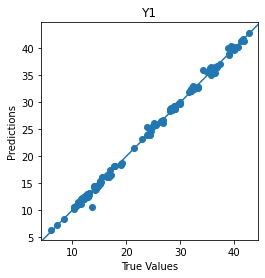

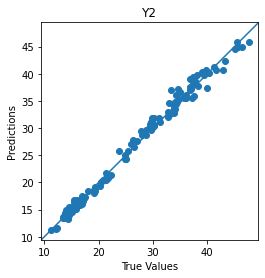

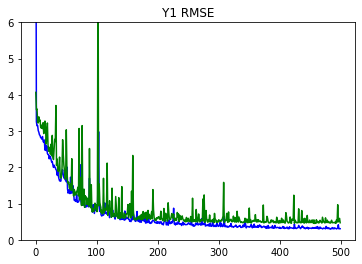

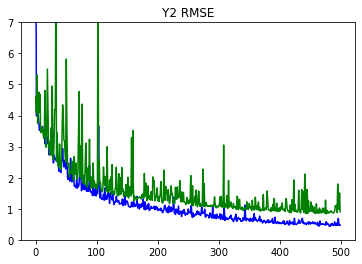

In [8]:
# Plot the loss and mse
Y_pred = model.predict(norm_test_X)
plot_diff(test_Y[0], Y_pred[0], title='Y1')
plot_diff(test_Y[1], Y_pred[1], title='Y2')
plot_metrics(metric_name='y1_output_root_mean_squared_error', title='Y1 RMSE', ylim=6)
plot_metrics(metric_name='y2_output_root_mean_squared_error', title='Y2 RMSE', ylim=7)